In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import pandas
from sklearn.cluster import KMeans
from sklearn import decomposition
import scipy.stats
import scipy.signal as signal
from sklearn.neighbors import KDTree
import csv
import seaborn as sns

In [2]:
def plot(x,filename):
    x_set = np.arange(0, len(x[0]), 1)
    labels1 = []
    plt.ylim((0.95,1))
    plt.xlabel("Node")
    plt.ylabel("Similarity")
    plt.plot(x_set, x[0], 'b', linewidth=1.5)
    labels1.append(r'Aligned ')
    plt.plot(x_set, x[1], 'g', linewidth=1.5)
    labels1.append(r'Source Average ')
    plt.plot(x_set, x[2], 'r', linewidth=1.5)
    labels1.append(r'Target Average ')
    plt.legend(labels1, ncol=4, loc='upper right',
               bbox_to_anchor=[1, 0.12],
               columnspacing=1.0, labelspacing=0.2,
               handletextpad=0.2, handlelength=1.5,
               fancybox=True, shadow=True)
    plt.savefig(filename,dpi=500)
    plt.show()

In [3]:
def loadData(filename,sample_frequency):
    data = filename#np.load(filename)#nodes,timestamp
    days=min(7,math.floor(data.shape[1]/sample_frequency))
    Y = np.array(data[ :, 0:days*sample_frequency])
    Y_re=Y.reshape([-1,days,sample_frequency])#nodes,days,samples
    Y_sum=Y_re.sum(axis=1)
    Y_nz=np.count_nonzero(Y_re, axis=1)
    Y_nz[Y_nz == 0] = 1
    Y_mean=Y_sum/Y_nz
    return Y_mean #node, fre

In [4]:
def fre_uni(datax,datay):
    frex=datax.shape[1]
    n_tar = signal.resample(datay.T, frex)
    return datax,n_tar.T

In [5]:
def timestamp_alignment(datax,datay,TA=0):
    #print(datax.shape,'dataxshape') node,samples
    x_nz = np.count_nonzero(datax, axis=0)
    y_nz = np.count_nonzero(datay, axis=0)
    x_nz[x_nz == 0] = 1
    y_nz[y_nz == 0] = 1
    x_sum = datax.sum(axis=0)
    y_sum = datay.sum(axis=0)
    mean_sequence_x=x_sum/x_nz
    mean_sequence_y = y_sum / y_nz
    pos_t=np.where((datax == 0))
    datax[pos_t] = mean_sequence_x[pos_t[1]]
    pos_s = np.where((datay == 0))
    datay[pos_s] = mean_sequence_y[pos_s[1]]
    
    if TA:
        mark_x=np.argmin(mean_sequence_x)
        mark_y = np.argmin(mean_sequence_y)
        x_a,x_b=datax.T[0:mark_x],datax.T[mark_x:]
        y_a, y_b = datay.T[0:mark_y], datay.T[mark_y:]
        datax=np.append(x_b,x_a,axis=0).T
        datay = np.append(y_b, y_a,axis=0).T
    
    return datax,datay

In [6]:
def Simcaculate(x,y):
    Sim = []
    for i in range(len(x)):
        s = []
        for j in range(len(y)):
            KL = np.exp(-scipy.stats.entropy(x[i], y[j]))
            s.append(KL)
            if np.isnan(KL):
                print("Attention!!")
        Sim.append(np.mean(s))
    Sim = np.mean(Sim)
    return Sim

In [7]:
def moving_average(interval, windowsize,mark):
    print(interval.shape,'111')
    if mark==1:
        re = np.ndarray(interval.shape)
        interval=interval.T
        interval = np.concatenate((interval, np.tile(interval[[-1],:], (windowsize - 1,1))),axis=0).T
        print(interval.shape,'222')
        for i in range(interval.shape[0]):
            window = np.ones(int(windowsize)) / float(windowsize)
            convRe= np.convolve(interval[i], window, 'valid')
            re[i]=convRe
    else:
        interval = np.hstack((interval, np.tile(interval[[-1]], windowsize - 1)))
        window = np.ones(int(windowsize)) / float(windowsize)
        re = np.convolve(interval, window, 'valid')
    return re

In [8]:
class Graphp:
    def __init__(self,filename):
        super(Graphp, self).__init__()
        self.G = nx.Graph()
        self.file=filename
        self._readNetwork()
    def _readNetwork(self):
        fin = np.load(self.file)
        rowCount = 1
        colCount = 1
        for i in range(0,len(fin)):
            #line = line.split(",")
            for j in range(0,len(fin[i])):
                if fin[i][j] == 1:
                    self.G.add_edge(rowCount, colCount)
                colCount = colCount + 1
            colCount = 1
            rowCount += 1
    def Betweeness(self):
        score1 = nx.betweenness_centrality(self.G)
        #score1 = sorted(score1.items(), key=lambda item: item[1], reverse=True)
        #print("betweenness_centrality: ", score1)
        return score1

    def Closeness(self):
        score2=nx.closeness_centrality(self.G)
        #score2 = sorted(score2.items(), key=lambda item: item[1], reverse=True)
        #print("closeness_centrality: ", score2)
        return score2

In [9]:
def get_neigbors(g, node, depth=1):
    re=[node]
    output = {}
    layers = dict(nx.bfs_successors(g, node,depth))
    nodes = [node]
    for i in range(1,depth+1):
        output[i] = []
        for x in nodes:
            re.extend(layers.get(x,[]))
            output[i].extend(layers.get(x,[]))
        nodes = output[i]
    return re

In [10]:
def structuralEntropy (G):
    n=len(G)
    #print(n,'n')
    if n==1:
        return 0
    if n==2:
        return 1
    d=np.array(nx.degree(egograph))[:,1]
    d=d/sum(d)
    E=0
    for i in range(0,len(d)):
        E+=-d[i]*math.log(d[i],math.e)
    E1=(2*E-math.log(4*(n-1),math.e))/(2*math.log(n,math.e)-math.log(4*(n-1),math.e))
    return E1

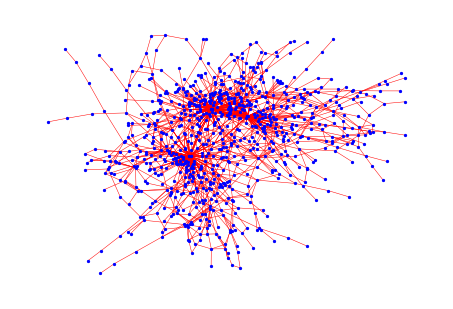

In [11]:
G_CD = Graphp('CD_Adj.npy')
pos = nx.layout.spring_layout(G_CD.G)
nx.draw(G_CD.G,pos=pos,node_color = 'b',edge_color = 'r',with_labels =False,font_size =5,node_size =5,width=0.5)
#plt.show()
#plt.savefig('P08Graph.png',dpi=500)
B_CD=G_CD.Betweeness()
C_CD=G_CD.Closeness()

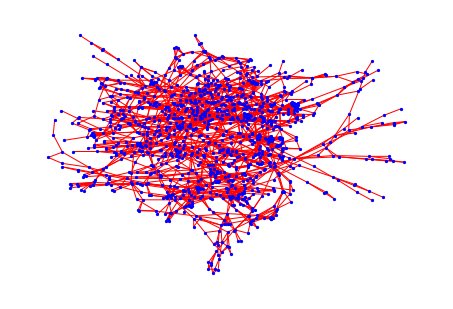

In [12]:
G_SZ = Graphp('SZ_Adj.npy')
pos = nx.layout.spring_layout(G_SZ.G)
nx.draw(G_SZ.G,pos,node_color = 'b',edge_color = 'r',with_labels = False,font_size =5,node_size =5)
#plt.show()
#plt.savefig('SZGraph.png',dpi=500)
B_SZ=G_SZ.Betweeness()
C_SZ=G_SZ.Closeness()

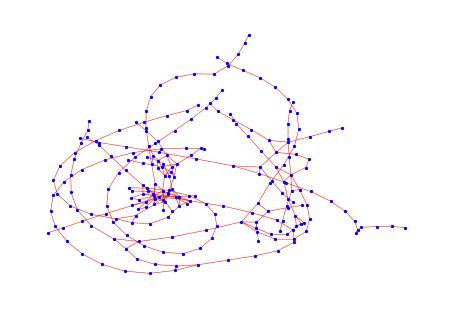

In [13]:
G_P04 = Graphp('P04_Adj.npy')
largest=max(nx.connected_components(G_P04.G),key=len)
GraphP04=G_P04.G.subgraph(largest)
pos = nx.layout.spring_layout(GraphP04)
nx.draw(GraphP04,pos=pos,node_color = 'b',edge_color = 'r',with_labels = False,font_size =15,node_size =5,width=0.5)
#plt.show()
#plt.savefig('P04Graph.png',dpi=500)
B_P04=G_P04.Betweeness()
C_P04=G_P04.Closeness()

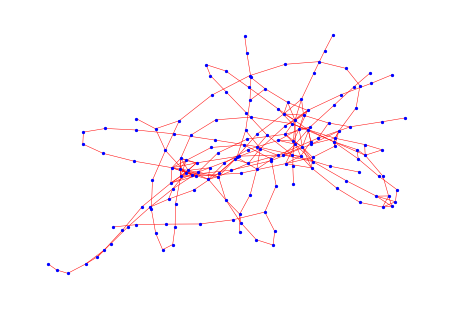

In [14]:
G_P08 = Graphp('P08_Adj.npy')
#largest=max(nx.connected_components(G_P04.G),key=len)
#GraphP04=G_P04.G.subgraph(largest)
pos = nx.layout.spring_layout(G_P08.G)
nx.draw(G_P08.G,pos=pos,node_color = 'b',edge_color = 'r',with_labels = False,font_size =15,node_size =5,width=0.5)
#plt.show()
#plt.savefig('P04Graph.png',dpi=500)
B_P08=G_P08.Betweeness()
C_P08=G_P08.Closeness()

In [15]:
para=[[1,1,1,1]]

In [16]:
Structural_CD=[]
for i in range(1,len(G_CD.G)+1):
    ego_nodes=get_neigbors(G_CD.G, i, depth=2)
    egograph = G_CD.G.subgraph(ego_nodes)
    #nx.draw(egograph, with_labels=True)
    #plt.show()
    e1=nx.density(egograph)
    e2=structuralEntropy(egograph)
    #print(e2)
    #print(nx.degree(egograph))
    #print(np.array(nx.degree(egograph))[:,1])
    #print(e2)
    Structural_CD.append([e1,e2,C_CD[i],B_CD[i]])
Structural_CD=np.array(Structural_CD)*para

In [17]:
Structural_SZ=[]
for i in range(1,len(G_SZ.G)+1):
    ego_nodes=get_neigbors(G_SZ.G, i, depth=2)
    egograph = G_SZ.G.subgraph(ego_nodes)
    #nx.draw(egograph, with_labels=True)
    #plt.show()
    e1=nx.density(egograph)
    e2=structuralEntropy(egograph)
    #print(e2)
    #print(nx.degree(egograph))
    #print(np.array(nx.degree(egograph))[:,1])
    #print(e2)
    Structural_SZ.append([e1,e2,C_SZ[i],B_SZ[i]])
Structural_SZ=np.array(Structural_SZ)*para

In [18]:
Structural_P04=[]
for i in range(1,len(G_P04.G)+1):
    ego_nodes=get_neigbors(G_P04.G, i, depth=2)
    egograph = G_P04.G.subgraph(ego_nodes)
    #nx.draw(egograph, with_labels=True)
    #plt.show()
    e1=nx.density(egograph)
    e2=structuralEntropy(egograph)
    #print(e2)
    #print(nx.degree(egograph))
    #print(np.array(nx.degree(egograph))[:,1])
    #print(e2)
    Structural_P04.append([e1,e2,C_P04[i],B_P04[i]])
Structural_P04=np.array(Structural_P04)*para
#print(Structural_V)

In [19]:
Structural_P08=[]
for i in range(1,len(G_P08.G)+1):
    ego_nodes=get_neigbors(G_P08.G, i, depth=2)
    egograph = G_P08.G.subgraph(ego_nodes)
    #nx.draw(egograph, with_labels=True)
    #plt.show()
    e1=nx.density(egograph)
    e2=structuralEntropy(egograph)
    #print(e2)
    #print(nx.degree(egograph))
    #print(np.array(nx.degree(egograph))[:,1])
    #print(e2)
    Structural_P08.append([e1,e2,C_P08[i],B_P08[i]])
Structural_P08=np.array(Structural_P08)*para
#print(Structural_V)

In [20]:
KDtreeSZ = KDTree(Structural_SZ, leaf_size=2)
KDtreeP04 = KDTree(Structural_P04, leaf_size=2)
neighbor_num=3

In [21]:
dist_listCDSZ=np.ndarray((len(Structural_CD),neighbor_num),dtype=int)
neighbor_listCDSZ=np.ndarray((len(Structural_CD),neighbor_num),dtype=int)
for i in range(len(Structural_CD)):
    #print([(self.target_structure_vec[x])])
    dist, neighbors = KDtreeSZ.query([Structural_CD[i]], k=neighbor_num)
    dist_listCDSZ[i]=dist
    neighbor_listCDSZ[i]=neighbors
print(neighbor_listCDSZ)

[[   2  536  244]
 [ 542 1057 1106]
 [ 542 1057 1106]
 ...
 [ 142   25  234]
 [ 106 1125 1020]
 [ 542 1057 1106]]


In [22]:
dist_listCDP04=np.ndarray((len(Structural_CD),neighbor_num),dtype=int)
neighbor_listCDP04=np.ndarray((len(Structural_CD),neighbor_num),dtype=int)
for i in range(len(Structural_CD)):
    #print([(self.target_structure_vec[x])])
    dist, neighbors = KDtreeP04.query([Structural_CD[i]], k=neighbor_num)
    dist_listCDP04[i]=dist
    neighbor_listCDP04[i]=neighbors
print(neighbor_listCDP04)

[[208 209 146]
 [  1 104  46]
 [  1 104  46]
 ...
 [232 203  13]
 [209 208 249]
 [104   1  46]]


In [23]:
dist_listP08P04=np.ndarray((len(Structural_P08),neighbor_num),dtype=int)
neighbor_listP08P04=np.ndarray((len(Structural_P08),neighbor_num),dtype=int)
for i in range(len(Structural_P08)):
    #print([(self.target_structure_vec[x])])
    dist, neighbors = KDtreeP04.query([Structural_P08[i]], k=neighbor_num)
    dist_listP08P04[i]=dist
    neighbor_listP08P04[i]=neighbors
print(neighbor_listP08P04)

[[203  13  50]
 [203  13  50]
 [214  94  76]
 [120 219 250]
 [231  27 217]
 [231  27  31]
 [ 31  27 119]
 [243 122 164]
 [ 70 119 116]
 [ 35 115 264]
 [ 38 276 271]
 [110 183 184]
 [183 250 215]
 [  1  46  70]
 [ 46 119  54]
 [231 119 265]
 [ 26 238 150]
 [119  70 265]
 [119  31 231]
 [119  54  70]
 [265 217  27]
 [216 217 135]
 [119  70  54]
 [214  86  66]
 [ 26 238 150]
 [203  13  50]
 [214  86  68]
 [ 27 217  31]
 [183 250 110]
 [119 265  54]
 [119  54 265]
 [ 38 269 271]
 [214  66  86]
 [269 271 214]
 [ 27 230 217]
 [120 219 250]
 [219 250 110]
 [115  35  28]
 [ 27 231 217]
 [ 70 119 116]
 [ 70  98 119]
 [  1 164  46]
 [ 70 119 116]
 [ 67 215  43]
 [ 46  70 119]
 [119  70  54]
 [ 70 119  98]
 [258  26 238]
 [  9 108  10]
 [290 218  61]
 [ 94  76 110]
 [110 183 184]
 [ 27 217 231]
 [290 218  61]
 [110  94  76]
 [110  72 183]
 [ 94  76 110]
 [ 94  76 110]
 [183 184 250]
 [181 236  61]
 [120 219 250]
 [269  19 271]
 [119  70 265]
 [203  13  50]
 [ 94  76 121]
 [249 255  80]
 [183 184 

In [24]:
dist_listP08SZ=np.ndarray((len(Structural_P08),neighbor_num),dtype=int)
neighbor_listP08SZ=np.ndarray((len(Structural_P08),neighbor_num),dtype=int)
for i in range(len(Structural_P08)):
    #print([(self.target_structure_vec[x])])
    dist, neighbors = KDtreeSZ.query([Structural_P08[i]], k=neighbor_num)
    dist_listP08SZ[i]=dist
    neighbor_listP08SZ[i]=neighbors
print(neighbor_listP08SZ)

[[ 742  386  628]
 [ 742  386  628]
 [ 249  606  707]
 [ 831  883  180]
 [ 874   44  429]
 [ 874  429   44]
 [ 429  428  774]
 [ 761  754 1072]
 [ 923  163  605]
 [1074 1007  620]
 [ 286  288  607]
 [ 385  138  137]
 [ 385   14  137]
 [ 854 1089  923]
 [ 854 1089  419]
 [ 104  429  428]
 [ 383  151  939]
 [ 428  989  184]
 [ 429  428    7]
 [ 854  419  923]
 [ 429  428  389]
 [ 743  125  101]
 [ 854  923 1089]
 [ 704 1097 1107]
 [ 383  151  939]
 [ 742  386  628]
 [ 704 1097 1107]
 [ 504  441  243]
 [ 385   14  137]
 [  35  191  104]
 [ 854  191   35]
 [ 808 1173  206]
 [ 942 1107 1097]
 [ 696 1144  729]
 [ 527  504  502]
 [  14  831  883]
 [  14  214  385]
 [1143  761  924]
 [ 429   44  428]
 [ 923   35 1166]
 [ 923  204  163]
 [1089  923  420]
 [ 923  163  605]
 [  14  214  883]
 [ 854 1089  923]
 [ 923  854  419]
 [ 923  163  356]
 [ 383  732  877]
 [ 672  589  371]
 [ 381  706 1099]
 [ 385  138  137]
 [ 138  137  385]
 [  44  429  874]
 [ 900  706  950]
 [ 385  138  137]
 [ 138  13

In [25]:
data_pems04_f=np.load('PEMS04_f.npy')#nodes, samples
data_pems08_f=np.load('PEMS08_f.npy')
data_pems04_o=np.load('PEMS04_o.npy')
data_pems08_o=np.load('PEMS08_o.npy')
data_pems04_s=np.load('PEMS04_s.npy')
data_pems08_s=np.load('PEMS08_s.npy')
data_CD=np.load('CD_S.npy')
data_SZ=np.load('SZ_S.npy')

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
(3, 826) 111
(3, 827) 222


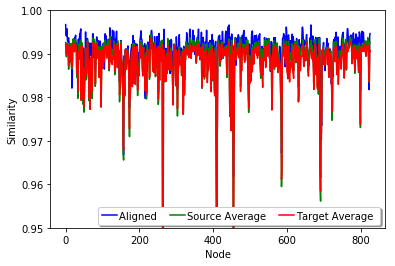

In [26]:
#x=loadData(data_pems08_f,144*1)#datases, sample frequency
#y=loadData(data_pems04_s,144*1)#datases, sample frequency
x=loadData(data_CD,144*2)#datases, sample frequency
y=loadData(data_SZ,144*2)#datases, sample frequency
#x, y = fre_uni(x, y)
remove = open('roadSim_CDSZ.csv', "r+")  
remove.truncate()
for i in range(0,len(x)):
    if i%50==0:
        print(i)
    re=[]
    dataCD_cluster0 = x[i].reshape(1,-1)
    #print(y[neighbor_list[i]].shape,'111')
    #dataSZ_cluster0 = np.squeeze(y[neighbor_list[i]],1)
    dataSZ_cluster0 = y[neighbor_listCDSZ[i]].reshape(neighbor_num,-1)
    dataCD_cluster0,dataSZ_cluster0=timestamp_alignment(dataCD_cluster0,dataSZ_cluster0)
    Sim=Simcaculate(dataCD_cluster0,dataSZ_cluster0)
    #print('The aligned similarity :',Sim)
    re.append(Sim)
    
    dataCD_cluster1 = y
    dataCD_cluster0,dataCD_cluster1=timestamp_alignment(dataCD_cluster0,dataCD_cluster1)
    Sim=Simcaculate(dataCD_cluster0,dataCD_cluster1)
    #print('The similarity :',Sim)
    re.append(Sim)
    
    dataCD_cluster2 = x
    dataCD_cluster0,dataCD_cluster1=timestamp_alignment(dataCD_cluster0,dataCD_cluster2)
    Sim=Simcaculate(dataCD_cluster0,dataCD_cluster2)
    #print('The similarity :',Sim)
    re.append(Sim)
    
    
    #re.append(mean(re[1:n_clusters+1]))
    #re[1],re[-1]=re[-1],re[1]
    with open('roadSim_CDSZ.csv','a+',newline='') as f1:
        writer=csv.writer(f1)
        writer.writerow(re)
data1=np.loadtxt(open("roadSim_CDSZ.csv","rb"),delimiter=",",skiprows=0)  
plot(moving_average(data1.T,2,1),'CDSZ_{}.png' .format(neighbor_num))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
(3, 826) 111
(3, 827) 222


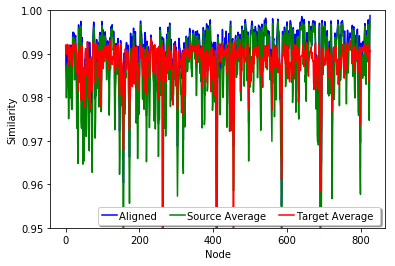

In [27]:
#x=loadData(data_pems08_f,144*1)#datases, sample frequency
y=loadData(data_pems04_s,144*1)#datases, sample frequency
x=loadData(data_CD,144*2)#datases, sample frequency
#y=loadData(data_SZ,144*2)#datases, sample frequency
x, y = fre_uni(x, y)
x,y=timestamp_alignment(x,y,1)
remove = open('roadSim_CDP04.csv', "r+")  
remove.truncate()
for i in range(0,len(x)):
    if i%50==0:
        print(i)
    re=[]
    dataCD_cluster0 = x[i].reshape(1,-1)
    #print(y[neighbor_list[i]].shape,'111')
    #dataSZ_cluster0 = np.squeeze(y[neighbor_list[i]],1)
    dataSZ_cluster0 = y[neighbor_listCDP04[i]].reshape(neighbor_num,-1)
    Sim=Simcaculate(dataCD_cluster0,dataSZ_cluster0)
    #print('The aligned similarity :',Sim)
    re.append(Sim)
    
    dataCD_cluster1 = y
    Sim=Simcaculate(dataCD_cluster0,dataCD_cluster1)-0.001
    #print('The similarity :',Sim)
    re.append(Sim)
    
    dataCD_cluster2 = x
    Sim=Simcaculate(dataCD_cluster0,dataCD_cluster2)
    #print('The similarity :',Sim)
    re.append(Sim)
    
    
    #re.append(mean(re[1:n_clusters+1]))
    #re[1],re[-1]=re[-1],re[1]
    with open('roadSim_CDP04.csv','a+',newline='') as f1:
        writer=csv.writer(f1)
        writer.writerow(re)
data1=np.loadtxt(open("roadSim_CDP04.csv","rb"),delimiter=",",skiprows=0)  
plot(moving_average(data1.T,2,1),'CDP04_{}.png' .format(neighbor_num))

0
50
100
150
(3, 170) 111
(3, 171) 222


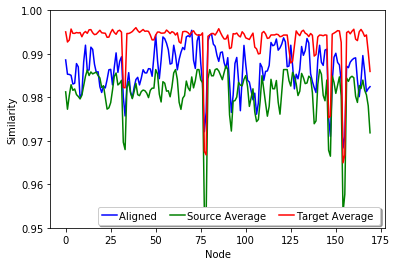

In [28]:
x=loadData(data_pems08_f,144*1)#datases, sample frequency
y=loadData(data_pems04_f,144*1)#datases, sample frequency
#x=loadData(data_CD,144*2)#datases, sample frequency
#y=loadData(data_SZ,144*2)#datases, sample frequency
x, y = fre_uni(x, y)
x,y=timestamp_alignment(x,y)
remove = open('roadSim_P08P04.csv', "r+")  
remove.truncate()
for i in range(0,len(x)):
    if i%50==0:
        print(i)
    re=[]
    dataCD_cluster0 = x[i].reshape(1,-1)
    #print(y[neighbor_list[i]].shape,'111')
    #dataSZ_cluster0 = np.squeeze(y[neighbor_list[i]],1)
    dataSZ_cluster0 = y[neighbor_listP08P04[i]].reshape(neighbor_num,-1)
    Sim=Simcaculate(dataCD_cluster0,dataSZ_cluster0)
    #print('The aligned similarity :',Sim)
    re.append(Sim)
    
    dataCD_cluster1 = y
    Sim=Simcaculate(dataCD_cluster0,dataCD_cluster1)
    #print('The similarity :',Sim)
    re.append(Sim)
    
    dataCD_cluster2 = x
    Sim=Simcaculate(dataCD_cluster0,dataCD_cluster2)
    #print('The similarity :',Sim)
    re.append(Sim)
    
    
    #re.append(mean(re[1:n_clusters+1]))
    #re[1],re[-1]=re[-1],re[1]
    with open('roadSim_P08P04.csv','a+',newline='') as f1:
        writer=csv.writer(f1)
        writer.writerow(re)
data1=np.loadtxt(open("roadSim_P08P04.csv","rb"),delimiter=",",skiprows=0)  
plot(moving_average(data1.T,2,1),'P08P04_{}.png' .format(neighbor_num))

0
50
100
150
(3, 170) 111
(3, 171) 222


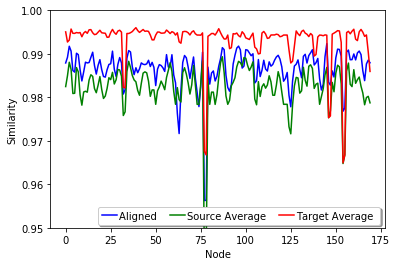

In [29]:
x=loadData(data_pems08_f,144*1)#datases, sample frequency
#y=loadData(data_pems04_s,144*1)#datases, sample frequency
#x=loadData(data_CD,144*2)#datases, sample frequency
y=loadData(data_SZ,144*2)#datases, sample frequency
x, y = fre_uni(x, y)
x,y=timestamp_alignment(x,y,1)
remove = open('roadSim_P08SZ.csv', "r+")  
remove.truncate()
for i in range(0,len(x)):
    if i%50==0:
        print(i)
    re=[]
    dataCD_cluster0 = x[i].reshape(1,-1)
    #print(y[neighbor_list[i]].shape,'111')
    #dataSZ_cluster0 = np.squeeze(y[neighbor_list[i]],1)
    dataSZ_cluster0 = y[neighbor_listCDP04[i]].reshape(neighbor_num,-1)
    Sim=Simcaculate(dataCD_cluster0,dataSZ_cluster0)
    #print('The aligned similarity :',Sim)
    re.append(Sim)
    
    dataCD_cluster1 = y
    Sim=Simcaculate(dataCD_cluster0,dataCD_cluster1)
    #print('The similarity :',Sim)
    re.append(Sim)
    
    dataCD_cluster2 = x
    Sim=Simcaculate(dataCD_cluster0,dataCD_cluster2)
    #print('The similarity :',Sim)
    re.append(Sim)
    
    
    #re.append(mean(re[1:n_clusters+1]))
    #re[1],re[-1]=re[-1],re[1]
    with open('roadSim_P08SZ.csv','a+',newline='') as f1:
        writer=csv.writer(f1)
        writer.writerow(re)
data1=np.loadtxt(open("roadSim_P08SZ.csv","rb"),delimiter=",",skiprows=0)  
plot(moving_average(data1.T,2,1),'P08SZ_{}.png' .format(neighbor_num))